# Assignment 4

We have a vehicle which needs to pass a known test track. You are given values 
$Preq(t)$ for each time $t=1,..., T$
which the vehicle's wheels needs to exert in order to successfully pass this test track.

The vehicle has a combustion engine, a motor/generator connected to a battery, and a friction break. Motor/generator can act either as a motor when it uses energy stored in the battery to power the wheels, or as a generator when it extracts the power from the wheels (regenerative breaking) or the engine to store it in the battery.
$Preq(t)$ is positive when the wheels need power, e.g. vehicle is ascending a hill or accelerating: power for the wheels needs to be provided by the combustion engine and/or the motor/generator which extracts the power stored in the battery. When $Preq(t)$ is negative (e.g. because vehicle is descending a hill), the power is extracted by the motor/generator which can store it in the battery and/or by the friction break.

Power is conserved, i.e., at each time $t$, we have $Preq(t) = Peng(t) + Pmg(t) - Pbr(t)$
where 
$0 ≤ Peng(t) ≤ Pengmax $ is power produced by the combustion engine, 
$Pmgmin ≤ Pmg(t) ≤ Pmgmax $ is power produced by the motor/generator (can be also negative if motor/generator absorbs power to charge the battery) and 
$Pbr(t) ≥ 0$ is the power absorbed by the friction break. See data bellow for the definition of the constants.

For every $t = 1,... T+1$, the energy  $E(t)$ in the battery has to be between $0$ and 
$Ebattmax$ representing the power stored in empty and full battery respectively. Moreover, we need to take into account the charging and discharging of the battery: we have 
$E (t+1) = E(t) - Pmg(t) - η |Pmg(t)|$ for $t = 1,... T$, see variable eta in the data. 
The term with coefficient η represents the energy lost due to the inefficiency of the battery and motor/generator. We also require  $E(T+1) =E(1)$ to make a fair comparison with a non-hybrid vehicle which has no battery.

The objective is to minimize the total fuel consumption of the vehicle over time, where the consumption at time 
$t$ is given by formula $Peng(t) + γ(Peng(t))^ 2$, i.e., a quadratic function. See data for the value of γ.

The Tasks are Four and they will be explained throught the project

# Data

Include the following code in your solution which generates data for you. The array Preq contains power requirements in all time steps. Bellow, are the bounds specifying the parameters of the engine, motor/generator, capacity of the battery, coefficient eta of the inefficiency of charging/discharging and coefficient gamma in the objective function.

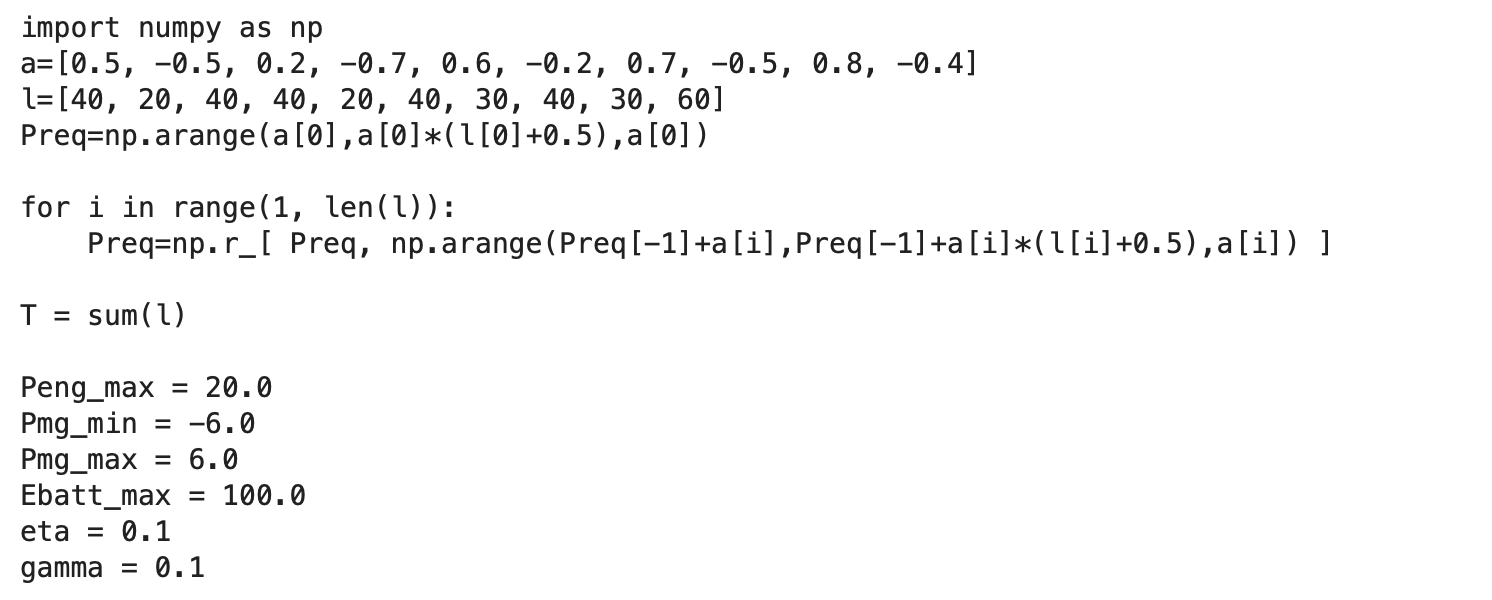

## A Note on Precision

LP solvers which we used so far always provided a precise feasible solutions. This is not always the case with the solvers for convex optimization. If you want better precision, see "eps" parameters in Solver options. However, default values are good enough for the purpose of this assignment.



## Importing and Generating Data

In [ ]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
a=[0.5, -0.5, 0.2, -0.7, 0.6, -0.2, 0.7, -0.5, 0.8, -0.4]
l=[40, 20, 40, 40, 20, 40, 30, 40, 30, 60]
Preq=np.arange(a[0],a[0]*(l[0]+0.5),a[0])

for i in range(1, len(l)):
    Preq=np.r_[ Preq, np.arange(Preq[-1]+a[i],Preq[-1]+a[i]*(l[i]+0.5),a[i]) ] 

T = sum(l)

Peng_max = 20.0
Pmg_min = -6.0
Pmg_max = 6.0
Ebatt_max = 100.0
eta = 0.1
gamma = 0.1

# Task 1 + Task 2 : formulate this minimization problem as a convex program and solve your convex program with cvxpy library and plot it 


Task 1: 

It is almost convex, just one set of constraints is problematic. Hint: Try to relax it, only one inequality is important, but provide an explanation (e.g. in the comments of your code) why your formulation is equivalent.


Task 2:

Link to the library: https://www.cvxpy.org/. Present the solution using a clear and well explained plot generated by matplotlib which was also used in the previous assignment.

By formulating the minimization problem we will need to relax one of the constraints in order for it to become convex. 

The constraint in question is the one represented by the following equation:

$ E(t+1) = E(t) - P_{mg}(t) - η |P_{mg}(t)| $ 

where $ η |P_{mg}(t)| $ represents the energy lost due to the inefficiency of the batter and of the motor or the generator.


We will modifiy by just simply relaxing it, that is unpacking the absolute value.

The constraints we will write are two: 

1. The first one will be derived from this equation

  $ E(t+1) = E(t) - P_{mg}(t) - η P_{mg}(t) $ 

  and it will be: 
  $  η P_{mg}(t) \leq - E(t+1) + E(t) - P_{mg}(t) ⇔  - η P_{mg}(t) \geq  E(t+1) - E(t) + P_{mg}(t) $

2. The second one will be derived from:

  $ E(t+1) = E(t) - P_{mg}(t) + η P_{mg}(t) $ 

  and it will be: 
  $  η P_{mg}(t) \geq  E(t+1) - E(t) + P_{mg}(t) ⇔ - η P_{mg}(t) \leq - E(t+1) + E(t) - P_{mg}(t) $



In [ ]:
#variables
Peng = cp.Variable(T) #"Power produced by combustion engine"
Pmg = cp.Variable(T) #"Power produced by the motor/generator"
Pbr = cp.Variable(T) #"Power absorbed by the friction break"
E = cp.Variable(T+1) #"Energy stored in the battery"



#constraints
constraints = []

constraints += [E[T] == E[0]]

tot_fuel_consumption = 0

for i in range(T): 
  constraints += [Peng[i] + Pmg[i] - Pbr[i] == Preq[i],
                  Peng[i] >= 0, Peng[i] <= Peng_max,
                  Pmg[i] >= Pmg_min, Pmg[i] <= Pmg_max,
                  Pbr>=0,
                  E[i] >= 0, E[i] <= Ebatt_max,
                  #absolute value constraints
                  eta * Pmg[i] <= -E[i+1] + E[i] - Pmg[i], #first constraint
                  eta * Pmg[i] >= E[i+1] - E[i] + Pmg[i]] #second constraint
    
  #objective
  #since we need minimize the total fuel consumption of the veichle, let's sum up the fuel consumption               
  tot_fuel_consumption += ((Peng[i]) + (cp.sum_squares(Peng[i])*gamma))

  
prob = cp.Problem(cp.Minimize(tot_fuel_consumption), constraints)
res_normal = prob.solve(solver = cp.ECOS)
print(f"total fuel consumption of the vehicle - normal car - normal objective: {res_normal}")

total fuel consumption of the vehicle - normal car - normal objective: 5077.526453029285


## Plot

Plot of the Power produced by the combustion engine over time

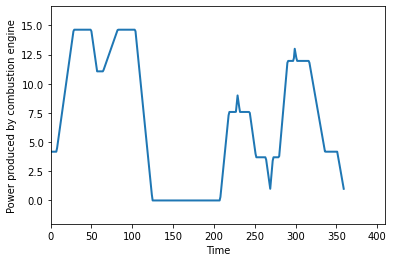

In [ ]:
fig, ax = plt.subplots()

x = [i for i in range(T)]

ax.plot(x, Peng.value, linewidth=2.0)

plt.xlabel('Time')
plt.ylabel("Power produced by combustion engine")

ax.set(xlim=(0, T+50),
       ylim=(min(Peng.value)-2, max(Peng.value)+2))

plt.show()

Plot of the Power produced by the motor/generator over time

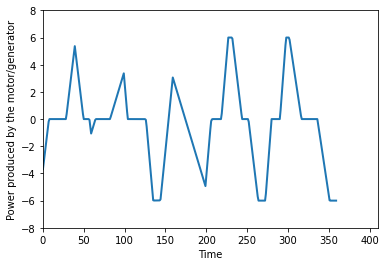

In [ ]:
fig, ax = plt.subplots()

x = [i for i in range(T)]

ax.plot(x, Pmg.value, linewidth=2.0)
plt.xlabel('Time')
plt.ylabel("Power produced by the motor/generator")

ax.set(xlim=(0, T+50),
       ylim=(min(Pmg.value)-2, max(Pmg.value)+2))

plt.show()

Plot of the power absorbed by the friction break over time

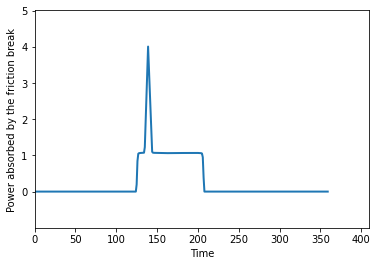

In [ ]:
fig, ax = plt.subplots()

x = [i for i in range(T)]

ax.plot(x, Pbr.value, linewidth=2.0)
plt.xlabel('Time')
plt.ylabel("Power absorbed by the friction break")

ax.set(xlim=(0, T+50),
       ylim=(min(Pbr.value)-1, max(Pbr.value)+1))

plt.show()

Plot of the energy stored in the battery over time

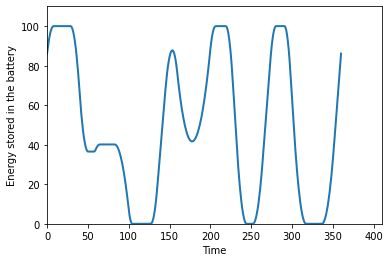

In [ ]:
fig, ax = plt.subplots()

x = [i for i in range(T+1)]

ax.plot(x, E.value, linewidth=2.0)

plt.xlabel('Time')
plt.ylabel("Energy stored in the battery")

ax.set(xlim=(0, T+50),
       ylim=(min(E.value), Ebatt_max+10))

plt.show()

# Task 3: comparison with a battery-less car

Change Ebatt_max to 0 and solve your program again to see how does it affect the power consumption. 

In [ ]:
Ebatt_max = 0

In [ ]:
#variables
Peng = cp.Variable(T) #"Power produced by combustion engine"
Pmg = cp.Variable(T) #"Power produced by the motor/generator"
Pbr = cp.Variable(T) #"Power absorbed by the friction break"
E = cp.Variable(T+1) #"Energy stored in the battery"


#constraints
constraints = []


constraints += [E[T] == E[0]]
                
tot_fuel_consumption = 0
for i in range(T): 
  constraints += [Peng[i] + Pmg[i] - Pbr[i] == Preq[i],
                  Peng[i] >= 0, Peng[i] <= Peng_max,
                  Pmg[i] >= Pmg_min, Pmg[i] <= Pmg_max,
                  Pbr>=0,
                  E[i] >= 0, E[i] <= Ebatt_max,
                  eta * Pmg[i] <= -E[i+1] + E[i] - Pmg[i],
                  eta * Pmg[i] >= E[i+1] - E[i] + Pmg[i]]

  #objective               
  tot_fuel_consumption += ((Peng[i]) + (cp.sum_squares(Peng[i])*gamma))

prob1 = cp.Problem(cp.Minimize(tot_fuel_consumption), constraints)
res_no_batt = prob1.solve(solver = cp.ECOS)
print(f"total fuel consumption of the vehicle - battery-less car - normal objective: {res_no_batt}")

total fuel consumption of the vehicle - battery-less car - normal objective: 5896.809001852089


# Task 4: handle glitches 

You may find out that although your program is equivalent, the solution found by the solver does not fulfill all the relaxed constraints with equality. This might happen during long periods of breaking when there is a lot of opportunities to charge the battery and sometimes the solver may decide to waste part of the power available to charge the battery (because it may charge it fully in the following time steps). There are two options how to proceed:



*   Postprocess the solution to get another solution with the same objective value where the relaxed constraints are preserved with equality. Such solution must exist since your program is equivalent to the original one. Hint: just move all the power from motor/generator to the battery and, if the battery is full, move it to the friction break.
*   Add a small term to the objective which will discourage such situation: for every $t = 1,..., T$ you can add a term $ϵ * max(0, -Pmg(t))$ for some small positive ε in order to discourage absorbing power by the motor/generator if it is not going to be used for charging the battery (because it is cheaper to absorb the power using the friction break) In case you decide to modify the objective, compare the power consumption achieved by your program to the power consumption achieved by the program with the original objective (to show that they are very similar with your choice of ε.



## Handle glitches for Normal Problem

In [ ]:
Ebatt_max = 100.0

In [ ]:
#variables
Peng = cp.Variable(T) #"Power produced by combustion engine"
Pmg = cp.Variable(T) #"Power produced by the motor/generator"
Pbr = cp.Variable(T) #"Power absorbed by the friction break"
E = cp.Variable(T+1) #"Energy stored in the battery"


#constraints
constraints = []


constraints += [E[T] == E[0]]
                
tot_fuel_consumption = 0

epsilon = 0.0001

for i in range(T): 
  constraints += [Peng[i] + Pmg[i] - Pbr[i] == Preq[i],
                  Peng[i] >= 0, Peng[i] <= Peng_max,
                  Pmg[i] >= Pmg_min, Pmg[i] <= Pmg_max,
                  Pbr>=0,
                  E[i] >= 0, E[i] <= Ebatt_max,
                  eta * Pmg[i] <= -E[i+1] + E[i] - Pmg[i],
                  eta * Pmg[i] >= E[i+1] - E[i] + Pmg[i]]

  #objective modified by a small epsilon value

  tot_fuel_consumption += Peng[i] + (cp.sum_squares(Peng[i])*gamma) + epsilon * cp.maximum(0,-Pmg[i])


prob2 = cp.Problem(cp.Minimize(tot_fuel_consumption), constraints)
res_epsilon = prob2.solve(solver = cp.ECOS)
print(f"total fuel consumption of the vehicle - normal car - epsilon-modified objective value: {res_epsilon}")

total fuel consumption of the vehicle - normal car - epsilon-modified objective value: 5077.561791651994


Evaluating the difference between the original problem and the newly defined one, to see the difference in the objective values.

In [ ]:
difference1 = res_epsilon - res_normal
print(f"difference for the normal car between the epsilon-modified objective value and normal objective value: {difference1}")

difference for the normal car between the epsilon-modified objective value and normal objective value: 0.035338622708877665


Indeed we get a very small difference between the value achieved by the last program and the program with original objective.

## Handle Glitches for Battery-Less problem

In [ ]:
Ebatt_max = 0

In [ ]:
#variables
Peng = cp.Variable(T) #"Power produced by combustion engine"
Pmg = cp.Variable(T) #"Power produced by the motor/generator"
Pbr = cp.Variable(T) #"Power absorbed by the friction break"
E = cp.Variable(T+1) #"Energy stored in the battery"


#constraints
constraints = []


constraints += [E[T] == E[0]]
                
tot_fuel_consumption = 0
epsilon = 0.0001
for i in range(T): 
  constraints += [Peng[i] + Pmg[i] - Pbr[i] == Preq[i],
                  Peng[i] >= 0, Peng[i] <= Peng_max,
                  Pmg[i] >= Pmg_min, Pmg[i] <= Pmg_max,
                  Pbr>=0,
                  E[i] >= 0, E[i] <= Ebatt_max,
                  eta * Pmg[i] <= -E[i+1] + E[i] - Pmg[i],
                  eta * Pmg[i] >= E[i+1] - E[i] + Pmg[i]]

  #objective               
  tot_fuel_consumption += Peng[i] + (cp.sum_squares(Peng[i])*gamma) + epsilon * cp.maximum(0,-Pmg[i])

prob1 = cp.Problem(cp.Minimize(tot_fuel_consumption), constraints)
res_no_batt_epsilon = prob1.solve(solver = cp.ECOS)
print(f"total fuel consumption of the vehicle - battery-less car - epsilon-modified objective: {res_no_batt_epsilon}")

total fuel consumption of the vehicle - battery-less car - epsilon-modified objective: 5896.809021680713


In [ ]:
difference2 = res_no_batt_epsilon - res_no_batt
print(f"difference for the battery-less car between the epsilon-modified objective value and normal objective value: {difference2}")

difference for the battery-less car between the epsilon-modified objective value and normal objective value: 1.9828624317597132e-05
